In [135]:
import xarray as xr
import numpy as np

# Load the netCDF file
dataset = xr.open_dataset('data/tasmin_W5E5v2.0_20010101-20101231.nc')

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset['tasmin']

# Define the temperature threshold
threshold = 263

# Set the window size
window_size = 30

# Define the latitude and longitude bounds for India
lat_min, lat_max = 8, 37
lon_min, lon_max = 68, 98
#lat_min, lat_max = 36, 37
#lon_min, lon_max = 77, 78

# Filter the dataset to India and the year 2001
india_dataset = dataset.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
india_temperature = india_dataset.sel(time='2001')['tasmin']
india_dataset

<xarray.Dataset>
Dimensions:  (lon: 60, lat: 58, time: 3652)
Coordinates:
  * lon      (lon) float64 68.25 68.75 69.25 69.75 ... 96.25 96.75 97.25 97.75
  * lat      (lat) float64 36.75 36.25 35.75 35.25 34.75 ... 9.75 9.25 8.75 8.25
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2010-12-31
Data variables:
    tasmin   (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    title:        WFDE5 over land merged with ERA5 over the ocean (W5E5) vers...
    institution:  Potsdam Institute for Climate Impact Research (PIK)
    project:      Inter-Sectoral Impact Model Intercomparison Project phase 3...
    contact:      ISIMIP cross-sectoral science team <info@isimip.org> <https...
    summary:      WFDE5 (with GPCC precipitation correction) over land merged...
    references:   Cucchi et al. (2020) <https://doi.org/10.5194/essd-12-2097-...
    version:      2.0

In [136]:
# Create a mask indicating if the temperature is below the threshold
mask = india_temperature < threshold
mask[0].astype(int)
# Count the number of consecutive days below the threshold
consecutive_days = np.zeros_like(mask, dtype=int)
consecutive_days[0] = mask[0].astype(int)

for i in range(1, len(mask)):
    consecutive_days[i] = mask[i].astype(int) * (consecutive_days[i-1] + 1)

# Find the maximum consecutive days for each latitude and longitude
max_consecutive_days = np.max(consecutive_days, axis=0)
max_consecutive_days

array([[ 3,  3,  1, ..., 30, 30, 48],
       [ 3,  0,  3, ..., 48, 20, 21],
       [14,  5,  6, ..., 90, 90, 73],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [137]:
# Extract the necessary variables
lat = india_dataset['lat']
lon = india_dataset['lon']
# Reshape the max_consecutive_days array based on latitude and longitude dimensions
reshaped_max_consecutive_days = max_consecutive_days.reshape(len(lat), len(lon))

# Find the latitude and longitude where the maximum consecutive days are greater than 30
indices = np.where(reshaped_max_consecutive_days > window_size)
latitudes = lat[indices[0]]
longitudes = lon[indices[1]]

# Print the latitude and longitude where the maximum consecutive days are greater than 30
#for lat, lon in zip(latitudes, longitudes):
#    print("Latitude:", lat.item(), "Longitude:", lon.item())

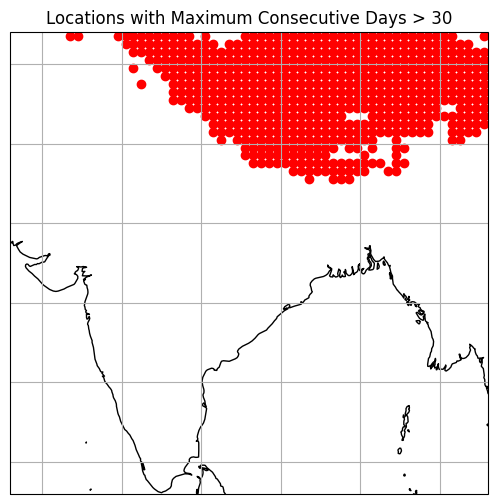

In [138]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# Plot the map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.gridlines()

# Plot the selected locations
ax.scatter(longitudes, latitudes, color='red', marker='o', transform=ccrs.PlateCarree())

# Set the plot extent to cover the entire world
ax.set_global()

# Set plot title and labels
ax.set_title('Locations with Maximum Consecutive Days > 30')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [144]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Load the netCDF file
dataset = xr.open_dataset('data/tasmin_W5E5v2.0_20010101-20101231.nc')

# Load land polygons dataset
land_polygons = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='10m',
    facecolor=cfeature.COLORS['land']
)

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset['tasmin']

# Define the temperature threshold
threshold = 263

# Set the window size
window_size = 30

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time='2001')['tasmin']

# Create a mask indicating if the temperature is below the threshold
mask = year_dataset < threshold

# Count the number of consecutive days below the threshold
consecutive_days = np.zeros_like(mask, dtype=int)
consecutive_days[0] = mask[0].astype(int)

for i in range(1, len(mask)):
    consecutive_days[i] = mask[i].astype(int) * (consecutive_days[i-1] + 1)

# Find the maximum consecutive days for each latitude and longitude
max_consecutive_days = np.max(consecutive_days, axis=0)

# Reshape the max_consecutive_days array based on latitude and longitude dimensions
reshaped_max_consecutive_days = max_consecutive_days.reshape(len(lat), len(lon))

# Find the latitude and longitude where the maximum consecutive days are greater than the window size
indices = np.where(reshaped_max_consecutive_days > window_size)
latitudes = lat[indices[0]]
longitudes = lon[indices[1]]

# Create a land mask using land polygons
land_mask = np.zeros_like(reshaped_max_consecutive_days, dtype=bool)
for i in range(len(latitudes)):
    lat_idx = np.abs(lat - latitudes[i]).argmin()
    lon_idx = np.abs(lon - longitudes[i]).argmin()
    land_mask[lat_idx, lon_idx] = True

# Apply the land mask to the selected locations
land_latitudes = latitudes[land_mask[indices]]
land_longitudes = longitudes[land_mask[indices]]

# Plot the map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add land and ocean background
ax.add_feature(land_polygons)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add map features
ax.coastlines()
ax.gridlines()

# Plot the selected land locations
ax.scatter(land_longitudes, land_latitudes, color='red', marker='o', transform=ccrs.PlateCarree())

# Set the plot extent to cover the entire world
ax.set_global()

# Set plot title and labels
ax.set_title('Land Locations with Maximum Consecutive Days > {}'.format(window_size))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


KeyboardInterrupt: 

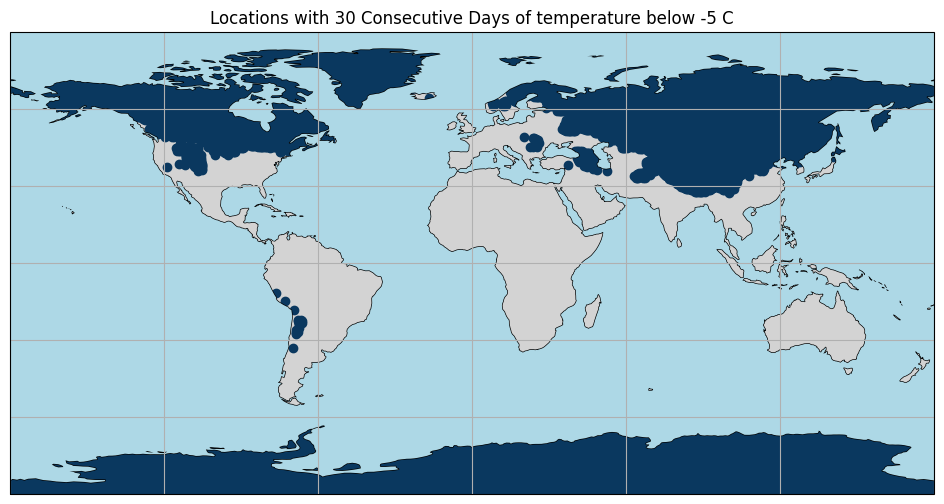

In [151]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Load the netCDF file
dataset = xr.open_dataset('data/tasmin_W5E5v2.0_20010101-20101231.nc')

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset['tasmin']

# Define the temperature threshold
threshold = 268

# Set the window size
window_size = 30

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time='2001')['tasmin']

# Create a mask indicating if the temperature is below the threshold
mask = year_dataset < threshold

# Count the number of consecutive days below the threshold
consecutive_days = np.zeros_like(mask, dtype=int)
consecutive_days[0] = mask[0].astype(int)

for i in range(1, len(mask)):
    consecutive_days[i] = mask[i].astype(int) * (consecutive_days[i-1] + 1)

# Find the maximum consecutive days for each latitude and longitude
max_consecutive_days = np.max(consecutive_days, axis=0)

# Reshape the max_consecutive_days array based on latitude and longitude dimensions
reshaped_max_consecutive_days = max_consecutive_days.reshape(len(lat), len(lon))

# Find the latitude and longitude where the maximum consecutive days are greater than the window size
indices = np.where(reshaped_max_consecutive_days > window_size)
latitudes = lat[indices[0]]
longitudes = lon[indices[1]]

# Plot the map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add map features
ax.coastlines()
ax.gridlines()

# Plot the selected locations
ax.scatter(longitudes, latitudes, color='#0a385f', marker='o', transform=ccrs.PlateCarree(), zorder=1)

# Add land and ocean background
ax.add_feature(cfeature.OCEAN, facecolor='lightblue',zorder=2)

# Set the plot extent to cover the entire world
ax.set_global()

# Set plot title and labels
ax.set_title('Locations with {} Consecutive Days of temperature below {} C'.format(window_size, threshold-273))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
